In [24]:
import numpy as np
import biotuner
from biotuner.biotuner_utils import *
from biotuner.biotuner_functions import *
from biotuner.biotuner_object import *
import mne

## Load dataset

In [4]:
#path = 'D:/Science/EEG_data/'
path = 'C:/Users/Dell/GitHub/CoCoBrainChannel/'
epochs = mne.read_epochs(path+'pareidolia_run2.fif')
#epochs = mne.read_epochs('C:/Users/Antoine/github/Data_EEG/pareidolia_run1.fif')
epochs = epochs.apply_baseline((-1.5, -0.1))
#epochs = epochs.crop(0.5, 7.5)
epochs_data = epochs.get_data()

Reading C:/Users/Dell/GitHub/CoCoBrainChannel/pareidolia_run2.fif ...


<ipython-input-4-450bd368b88c>:3: RuntimeWarning: This filename (C:/Users/Dell/GitHub/CoCoBrainChannel/pareidolia_run2.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs = mne.read_epochs(path+'pareidolia_run2.fif')


    Found the data of interest:
        t =   -1500.00 ...    8000.00 ms
        0 CTF compensation matrices available


C:\Users\Dell\Anaconda3\lib\site-packages\mne\io\tag.py:427: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  ch_name = ch_name[:np.argmax(ch_name == b'')].tostring()
C:\Users\Dell\Anaconda3\lib\site-packages\mne\io\tag.py:427: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  ch_name = ch_name[:np.argmax(ch_name == b'')].tostring()
C:\Users\Dell\Anaconda3\lib\site-packages\mne\io\tag.py:427: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  ch_name = ch_name[:np.argmax(ch_name == b'')].tostring()
C:\Users\Dell\Anaconda3\lib\site-packages\mne\io\tag.py:427: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  ch_name = ch_name[:np.argmax(ch_name == b'')].tostring()
C:\Users\Dell\Anaconda3\lib\site-packages\mne\io\tag.py:427: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  ch_name = ch_name[:np.argmax(ch_name == b'')].tostring()
C:\Users\Dell\Anaconda3\lib\site-packages\mne\io\tag.py

104 matching events found
Applying baseline correction (mode: mean)
Not setting metadata
0 projection items activated
Applying baseline correction (mode: mean)


## Phase-Amplitude Coupling

The comodulogram is a matrix representing the strength of the coupling between the phase of driver frequencies and the amplitude of signal frequencies. The 'pac' method allows to extract pairs of driver/signal frequencies that exhibit higher scores of coupling

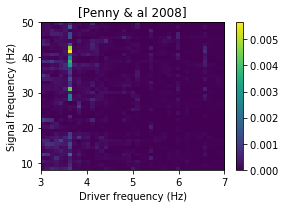

In [5]:
data = epochs_data[13][34][:] # Define data (single time series)
biotuning = biotuner(1000, data = data, peaks_function = 'harmonic_peaks', precision = 0.1, n_harm = 10,
                    ratios_n_harms = 5, ratios_inc_fit = False, ratios_inc = True, scale_cons_limit = 0.1) # Initialize biotuner object
pac_freqs = biotuning.pac(n_values = 30, plot=True, drive_precision = 0.1, max_drive_freq = 7, method = 'penny')

Different methods can be used to compute the PAC:
methods = ['ozkurt', 'canolty', 'tort', 'penny', 'vanwijk', 'duprelatour', 'colgin',
    'sigl', 'bispectrum']

[[3.6, 43.0],
 [3.6, 42.0],
 [3.6, 31.0],
 [3.6, 40.0],
 [3.6, 29.0],
 [3.6, 39.0],
 [3.6, 23.0],
 [3.6, 41.0],
 [3.6, 37.0],
 [3.6, 38.0]]

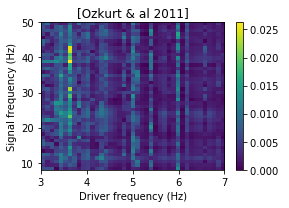

In [6]:
pac_freqs = biotuning.pac(plot=True, drive_precision = 0.1, max_drive_freq = 7, method = 'ozkurt')
pac_freqs

## Deriving tunings from PAC information

By computing the most frequent phase and amplitude frequencies from the 'pac_freqs' lists, we can derive a series of ratios by coupling each phase with each amplitude frequencies

In [7]:
pac_frequent = pac_most_frequent(pac_freqs, 3)
pac_frequent

[[38.0, 37.0, 41.0], [3.6]]

In [8]:
ratios = []
for i in range(len(pac_frequent[0])):
    for j in range(len(pac_frequent[1])):
        ratios.append(rebound(pac_frequent[0][i]/pac_frequent[1][j]))
        
ratios = sorted(ratios)
ratios

[1.284722222222222, 1.3194444444444444, 1.4236111111111112]

Another approach to derive tuning based on the information of the Phase-Amplitude Coupling would be to compute the ratios of each pairs of phase/amplitude frequencies, and then to apply the 'scale_reduction' function to extract the most consonant intervals. This is what the pac_mode function does.

In [9]:
pac_mode(pac_freqs, 6, function=dyad_similarity)

[1.0764, 1.3194, 1.3542, 1.3889, 1.4583, 1.5972]

In [10]:
pac_mode(pac_freqs, 10)

[1.0069,
 1.0764,
 1.2847,
 1.3194,
 1.3542,
 1.3889,
 1.4236,
 1.4583,
 1.4931,
 1.5972]

### Using coupled frequencies as generator interval

In [11]:
ratio = rebound(pac_freqs[0][1]/pac_freqs[0][0])
sp.Rational(ratio).limit_denominator(1000)

215/144

In [22]:
limit_steps = 16
stern_brocot_ratio = gen_interval_to_stern_brocot (ratio)
steps = Fraction(stern_brocot_ratio).limit_denominator(16).denominator
gen_int_tuning = sorted(generator_interval_tuning (interval = ratio, steps = steps, octave = 2))
gen_int_tuning

[1.0337411204007074,
 1.1146074459876543,
 1.1522155500222488,
 1.2423497586511218,
 1.2842680314375592,
 1.3847322915135056,
 1.4930555555555556,
 1.5434329228205006,
 1.6641708394954562,
 1.7203218281582187,
 1.8548972090971612,
 1.9174835191602446]

## Deriving euclidian rhythms from PAC information

In [23]:
from biotuner.dictionaries import *
pac_scale = pac_mode(pac_freqs, 10, function=dyad_similarity)
euclid_final, cons = consonant_euclid(pac_scale, n_steps_down = 3, limit_denom = 4, 
                                      limit_cons =1, limit_denom_final = 100)
interval_vectors = [interval_vector(x) for x in euclid_final]
strings = interval_vec_to_string(interval_vectors)
euclid_referent = euclid_string_to_referent(strings, dict_rhythms)
euclid_final, interval_vectors, euclid_referent

([[1, 0],
  [1, 0, 0],
  [1, 0, 0, 0],
  [1, 0, 0, 0, 1, 0, 0, 0],
  [1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0],
  [1, 0, 0, 1, 0, 0],
  [1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0],
  [1, 0, 1, 0, 1, 0],
  [1, 0, 1, 0, 1, 0, 1, 0],
  [1, 1, 1, 0],
  [1, 1, 1, 0, 1, 1, 1, 0],
  [1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0]],
 [[2],
  [3],
  [4],
  [4, 4],
  [4, 4, 4],
  [3, 3],
  [3, 3, 3, 3],
  [2, 2, 2],
  [2, 2, 2, 2],
  [1, 1, 2],
  [1, 1, 2, 1, 1, 2],
  [1, 1, 2, 1, 1, 2, 1, 1, 2]],
 ['None',
  'None',
  'None',
  'None',
  'None',
  'None',
  'It is periodic with four repetitions of E(1,3) = [100]. It is the (12/8)-time Fandago clapping pattern in the Flamenco music of southern Spain, where 1 denotes a loud clap and 0 soft clap.',
  'None',
  'None',
  'It is the archetypal pattern of the Cumbia from Colombia, as well as a Calypso rhythm from Trinidad. It is also a thirteenth century Persian rhythm called Khalif-e-saghil, as well as the trochoid choreic rhythmic pattern of ancient Greece.',
  'None',
 